# 歩行量とWi-Fiデータの比較


7月に並木君が修正したデータについて、階層線形モデルで行う。



手順:
 - ２日間のデータを訓練データとして、lmerにより、地点ごとの回帰係数（切片、傾き）を求める
 - その係数を用いて、もう１日のWi-Fiデータから、地点・時間ごとに予測値を求める
 - 両者の散布図をつくる

マニュアルページ：http://www.statsmodels.org/stable/mixed_linear.html

このipynb https://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/notebook/lmer_kofu201908tyk.ipynb



## データの読み込み

In [44]:
''' 地点の名前を得る '''
import csv
def getPointName(area, kind='name'):
    filename = {"kofu": "/var/www/html/kofu/kofu_position.csv",
               "fuefuki": "/var/www/html/ff/sensor_points.csv",
               "hakushu": "/home/toyoki/public_html/hakushu/points_hakushu.csv"}
    pointName = {}    
    with open(filename[area],"r") as f:
        reader = csv.reader(f)
        header = next(reader)
        for line in reader:
            if len(line) < 4:
                continue
            if kind=='group':
                pointName[line[0]] = line[4]
            else:
                pointName[line[0]] = line[3]
    return pointName


## 単純な散布図

データの読み込みがうまく行っているか確認

point      date  hour  all_device  global_device  local_device  \
0  kofu10  20181130    10         180             36           144   
1  kofu10  20181130    11         288             49           239   
2  kofu10  20181130    12         213             40           173   
3  kofu10  20181130    13         230             46           184   
4  kofu10  20181130    14         342             65           277   

   pedestrian  bicycle  bike    name group  
0          67       12     8  河野スポーツ    中央  
1          90       25    10  河野スポーツ    中央  
2         110       23     8  河野スポーツ    中央  
3          70       24    12  河野スポーツ    中央  
4          89       26     7  河野スポーツ    中央

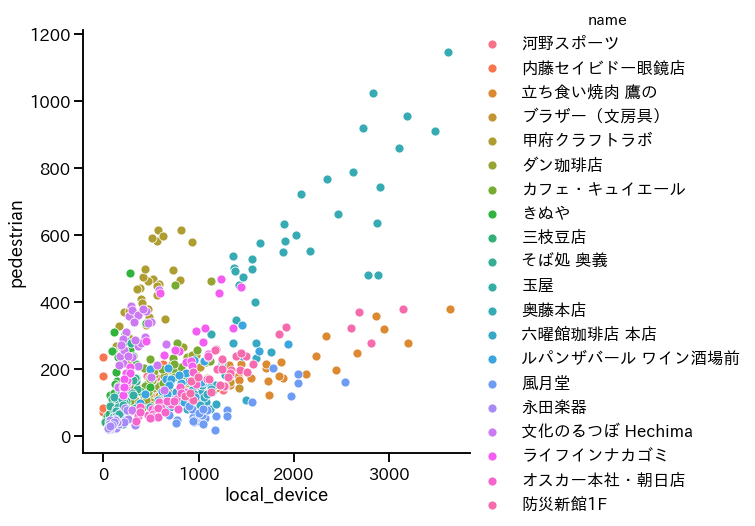

In [45]:
%matplotlib inline
# 甲府データの読み込み
import pandas as pd
import seaborn as sns

# テストデータ (並木によるデータ)
df = {}
wifi_data = pd.read_csv('/home/toyoki/work/kofu/reg_analysis201908/wifi_hourly_20181130-20181202.csv')
survey_data = pd.read_csv('/home/toyoki/work/kofu/reg_analysis201908/survey_hourly_20181130-20181202.csv')
df = pd.merge(wifi_data, survey_data, on=['point','date','hour'])
# 地点名
name_of_point = getPointName('kofu')
group_of_point = getPointName('kofu','group')
df['name'] = df['point'].map(name_of_point) # mapには辞書を。または、無名関数を与えてもよい (lambda x: name_of_point[x])
df['group'] = df['point'].map(group_of_point)
# 日にち等の限定 (なければdfそのものを描画)
df4plot = df
#df4plot = df.query('date!="20181130"') # 1130を除外
#df4plot = df.query('date=="20181130"') # 1130だけ
# 描画
sns.pairplot(x_vars=['local_device'], y_vars=['pedestrian'], data=df4plot, hue='name', height=7)

df4plot.head()

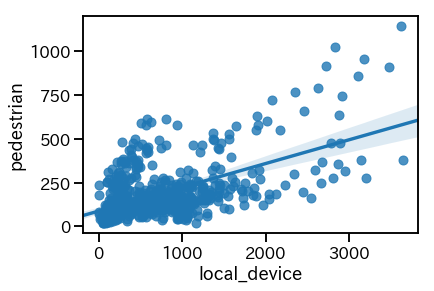

In [46]:
# seabornのregplotの利用：散布図だけではなく回帰線を引いてくれる (色の指定が困難)
sns.regplot('local_device','pedestrian', data=df4plot)

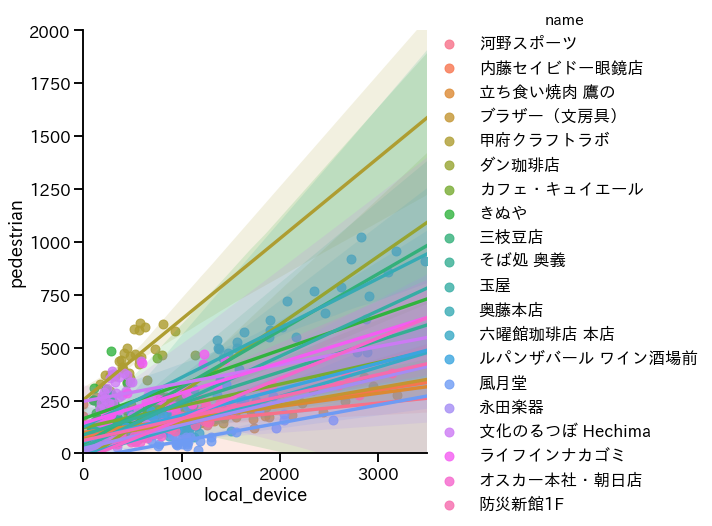

In [47]:
#  group毎に回帰線を引く (hueでグループのフィールド名を指定, 信頼区間を色付けしてくれるが、それがかえって見にくい)
# 階層線形モデルではなく、それぞれの地点データについて個別に回帰線を引いていることに注意　（⇒　あまり意味がない）
g = sns.lmplot(x='local_device',y='pedestrian', data=df4plot, hue='name', fit_reg=True, height=7)
g.set(xlim=(0,3500), ylim=(0,2000))

## 一般線形混合モデル（階層線形モデル）


**parameters**

 - <span class="mark">目的変数： response_var
 - <span class="mark">説明変数： explanatory_var</span></span>
 
この２つは下の方まで一貫して使う。


In [48]:

# 説明変数と目的変数選定　(重要)
response_var = 'pedestrian'
explanatory_var = 'local_device'


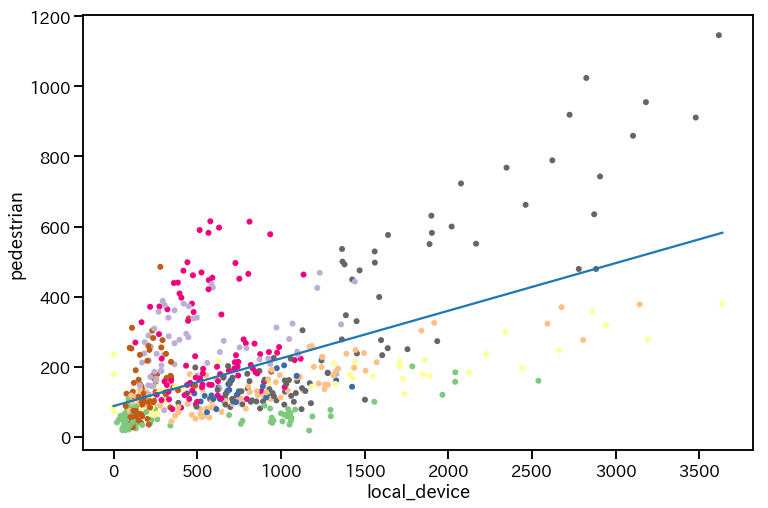

In [49]:
# OLMで求めた回帰係数の線を追加する
# seabornは使わない
# 色はDataFrameのフィールドとして用意する。各データ点（各行）ごとに色を指定するため、凡例は書けない

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# テストデータ日を除いた日を訓練データ(train_df)として係数算出 (OLS)
train_df = {}
# 甲府データの利用 (上記で読み込んだものを使う)
x_train = df[explanatory_var].values
y_train = df[response_var].values

import statsmodels.api as sm

model = sm.OLS(y_train, sm.add_constant(x_train))
result = model.fit()
#print(result.summary())

# パラメータの推定値を取得
a, b = result.params

line_x = [0, max(x_train)]
#print(line_x)
line_y = [a, a + b*line_x[1]]

# 描画
fig = plt.figure(figsize=(12, 8))
# Figure内にAxesを追加()
ax = fig.add_subplot(111) #...2
# nameでグループ分けして色をつける
df4plot['color'] = df4plot['point'].str.replace('kofu','').astype(int)
df4plot.plot(kind='scatter',x=explanatory_var, y=response_var, c='color',  colormap='Accent', colorbar=False, ax=ax)
ax.plot(line_x,line_y)
# ax.legend(ax.collections, list(grouped_df.groups.keys()), loc='upper')

In [50]:
# 混合線形モデル(mixedlm)での係数算出
import statsmodels.formula.api as smf

# 説明変数と目的変数選定
response_var = 'pedestrian'
explanatory_var = 'local_device'
formula4mixedlm = response_var + " ~ " + explanatory_var
re_formula4mixedlm = "~" + explanatory_var

md = smf.mixedlm(formula4mixedlm, df4plot, groups="point", re_formula= re_formula4mixedlm)
mdf = md.fit()

Intercept_common = mdf.fe_params.Intercept # 共通切片
coef_common = mdf.fe_params.local_device      # 共通傾き
random_coef = mdf.random_effects           # ランダム項
#print(random_coef)
coef = {}
for j in random_coef.keys(): # 共通とランダムの和を計算
    coef[j] = [random_coef[j]['point']+ Intercept_common, random_coef[j].local_device+ coef_common]
#  print(coef)


/opt/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

図を描くだけなら、結果のオブジェクトに含まれるfittedvalueというプロパティにデータがあるのでそれを用いればよい。（上のように求めた、回帰係数から推定値を計算しなくてもよい）

下のようにmdf.fittedvaluesをデータフレームの新たな列に加えて描画する。

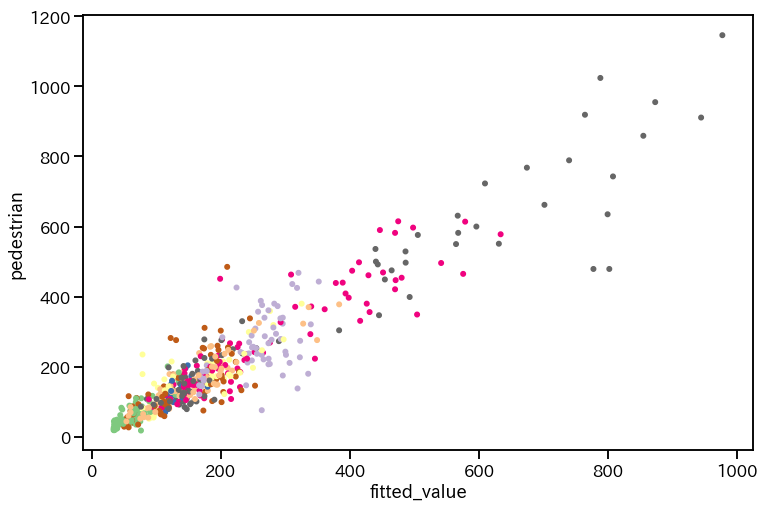

In [51]:
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
# Figure内にAxesを追加()
ax = fig.add_subplot(111) #...2
df4plot['color'] = df4plot['point'].str.replace('kofu','').astype(int) # 色
# 階層線形モデルの結果から直接、推定値を得る(fittedvalues)
df4plot['fitted_value'] = mdf.fittedvalues
df4plot['residue'] = mdf.resid
df4plot.plot(kind='scatter',x='fitted_value', y='pedestrian', c='color', colormap='Accent', colorbar=False, ax=ax)

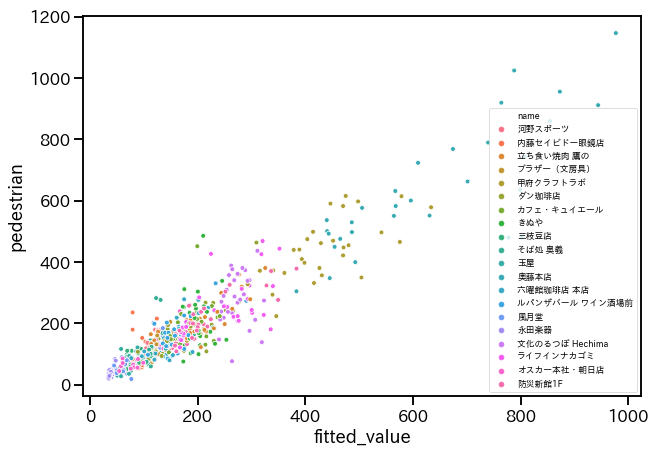

In [53]:
# 上記のseabornによる描画　（凡例を書いてくれる。 グループはhueで指定）
fig, ax = plt.subplots(1,1,figsize=(10, 7))
# ax = fig.add_subplot(111) # figureオブジェクトを作ってから、add_subplot() を使うのでもよい
sns.set_context('paper') # 印刷用
sns.scatterplot(y = response_var, x = 'fitted_value', data=df4plot, hue='name', ax=ax)

In [52]:
df4plot.head()
# residue (残差) = response_var (pedestrianなど) - fitted_value

point      date  hour  all_device  global_device  local_device  \
0  kofu10  20181130    10         180             36           144   
1  kofu10  20181130    11         288             49           239   
2  kofu10  20181130    12         213             40           173   
3  kofu10  20181130    13         230             46           184   
4  kofu10  20181130    14         342             65           277   

   pedestrian  bicycle  bike    name group  color  fitted_value    residue  
0          67       12     8  河野スポーツ    中央     10    105.774482 -38.774482  
1          90       25    10  河野スポーツ    中央     10    110.338923 -20.338923  
2         110       23     8  河野スポーツ    中央     10    107.167837   2.832163  
3          70       24    12  河野スポーツ    中央     10    107.696352 -37.696352  
4          89       26     7  河野スポーツ    中央     10    112.164699 -23.164699

In [90]:
'''
残差の標準偏差(std), 推定値の平均(mean)を計算
相対誤差平均 (mean relative error) mre = std/mean を計算
'''
err_result = df4plot.groupby('point').agg({'fitted_value': 'mean', 'residue': 'std' })
err_result['mre'] = err_result['residue']/err_result['fitted_value'] # 平均相対誤差
name_of_point = getPointName('kofu')
err_result = err_result.reset_index() # pointをインデックスからコラムに変更
err_result['name'] = err_result['point'].map(name_of_point)
err_result = err_result.rename(columns={'fitted_value':'mean_fitted_value', 'residue':'std_dev_residue'})
err_result = err_result.sort_values(by='mre')
err_result

point  mean_fitted_value  std_dev_residue       mre            name
4   kofu16         431.486161        75.568193  0.175135        甲府クラフトラボ
19   kofu9         215.466457        38.654858  0.179401          防災新館1F
2   kofu12         200.141370        37.896880  0.189351       立ち食い焼肉 鷹の
11  kofu22         635.942513       120.911129  0.190129            奥藤本店
3   kofu13         131.021307        25.217567  0.192469       ブラザー（文房具）
18   kofu8         101.687036        22.972690  0.225916      オスカー本社・朝日店
0   kofu10         116.951756        26.529669  0.226843          河野スポーツ
13  kofu24         165.187886        40.604672  0.245809  ルパンザバール ワイン酒場前
8    kofu2          70.683942        17.884383  0.253019            三枝豆店
5   kofu17         175.445058        45.049324  0.256772           ダン珈琲店
12  kofu23         141.824609        40.056489  0.282437       六曜館珈琲店 本店
17   kofu7         244.496024        71.049383  0.290595       ライフインナカゴミ
16   kofu5         272.506026        83.640396  0.306930  文化のるつぼ Hechima
6   kofu18         185.984182        59.538056  0.320124      カフェ・キュイエール
15   kofu4          39.422695        12.833031  0.325524            永田楽器
14   kofu3          79.139180        26.159610  0.330552             風月堂
10  kofu21          63.089076        21.426969  0.339630              玉屋
9   kofu20         124.673393        49.683831  0.398512          そば処 奥義
7   kofu19         197.470578        84.748298  0.429169             きぬや
1   kofu11          93.647418        46.228223  0.493641      内藤セイビドー眼鏡店

Text(0, 0.5, '歩行者数計測値')

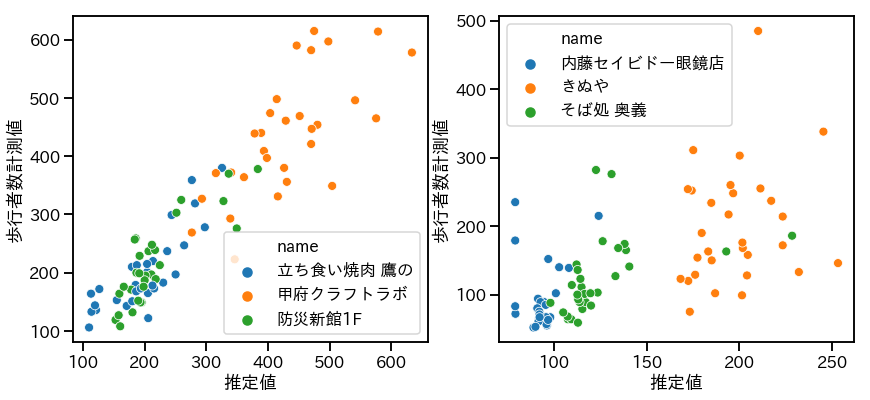

In [55]:
fig = plt.figure(figsize=(14, 6))
# Figure内にAxesを追加()
sns.set_context('talk')

# MAEが良い5カ所
ax = fig.add_subplot(121) #...2
sns_fig = sns.scatterplot(y= response_var, x='fitted_value',
                       data=df4plot.query("point in ['kofu16', 'kofu9', 'kofu12']"), hue='name', ax = ax)
#sns_fig.set(xlabel='推定値', ylabel='歩行者数計測値')

# MAEが悪い5カ所
ax2 = fig.add_subplot(122) #...2
sns.scatterplot(y=response_var, x='fitted_value',
                       data=df4plot.query("point in ['kofu11', 'kofu19', 'kofu20']"), hue='name', ax = ax2)
ax.set_xlabel('推定値')
ax.set_ylabel('歩行者数計測値')
ax2.set_xlabel('推定値')
ax2.set_ylabel('歩行者数計測値')

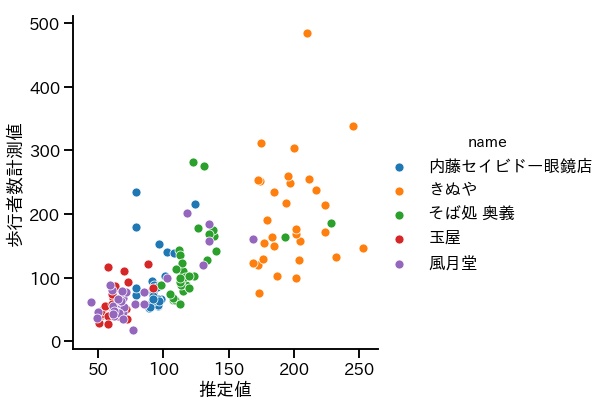

In [56]:
# MAEが悪い5カ所
'''
pairplotを使った描画例:
pairplotは、本来、複数のコラム間の相関をgrid型に表示する関数。ここでは一つだけなので、x_vars, y_varsが一つだけの要素にしてある
scatterplotで書くほうがよいが、凡例が自動的に外にでるところはありがたい
'''
sns.set_context('talk')
sns_fig = sns.pairplot(y_vars=[response_var], x_vars=['fitted_value'],
                       data=df4plot.query("point in ['kofu11', 'kofu19', 'kofu20','kofu21','kofu3']"), hue='name', height=6)
sns_fig.set(xlabel='推定値', ylabel='歩行者数計測値')

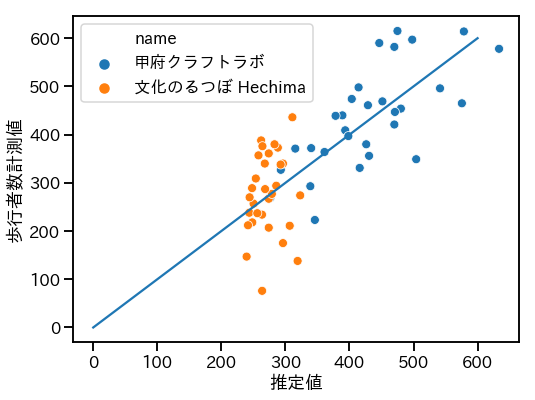

In [57]:
# 2か所描画
fig = plt.figure(figsize=(8, 6))
# Figure内にAxesを追加()
ax = fig.add_subplot(111) #...2
sns.set_context('talk')

sns_fig = sns.scatterplot(y=response_var, x='fitted_value',
                       data=df4plot.query("point in ['kofu16', 'kofu5']"), hue='name',ax =ax)
sns_fig.set(xlabel='推定値', ylabel='歩行者数計測値', )
ax.plot([0,600], [0,600])


精度が悪い地点の特徴は、横道が多い飲食街の地点と言えるのではないか。

概して、推定値の幅が狭く、歩行者の振れ幅が大きい。


## 2日間を訓練データ、もう1日をテストデータとした分析


In [84]:
# mixedlmでの地点ごとの係数を(目的日、地点)ごとに算出
# coef[テストデータ用ID][地点ID]  訓練データは地点データを除いた２日間
import statsmodels.formula.api as smf
coef = {}
train_df=[]
train_df.append(df4plot.query("date!=20181130"))
train_df.append(df4plot.query("date!=20181201"))
train_df.append(df4plot.query("date!=20181202"))
for i in range(len(train_df)):
    md = smf.mixedlm(formula4mixedlm, train_df[i], groups=train_df[i]["point"], re_formula=re_formula4mixedlm)
    mdf = md.fit()
    Intercept_common = mdf.fe_params.Intercept # 共通切片
    coef_common = mdf.fe_params.local_device      # 共通傾き
    random_coef = mdf.random_effects           # ランダム項
    coef[i] = {}
    for j in random_coef.keys(): # 共通とランダムの和を計算
        coef[i][j] = [random_coef[j].Group+ Intercept_common, random_coef[j].local_device+ coef_common]
#import pprint
#pprint.pprint(coef) # 係数を書き出してみる


/opt/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

              fitted_value  pedestrian
fitted_value      1.000000    0.904564
pedestrian        0.904564    1.000000
              fitted_value  pedestrian
fitted_value       1.00000     0.90387
pedestrian         0.90387     1.00000
              fitted_value  pedestrian
fitted_value      1.000000    0.919789
pedestrian        0.919789    1.000000


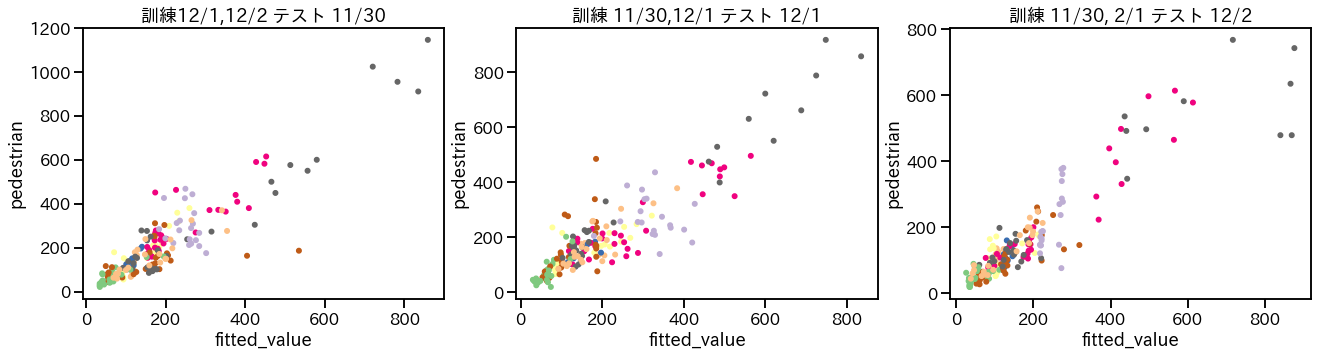

In [87]:
# 訓練データから得られた回帰係数を用いてテストデータ日のWi-Fiデータより歩行者数の予測値を計算
# 日ごとのテストデータ
df = [df4plot.query("date==20181130").reset_index(),
      df4plot.query("date==20181201").reset_index(),
      df4plot.query("date==20181202").reset_index()]

dfa = {} # 結果を入れるdataframe

for i in range(len(df)):
    predict_val = []
    for j in df[i].index:
        item = df[i].loc[j]
        this_coef = coef[i][item.point] # 地点ごとの係数
        predict_val.append(item.local_device*this_coef[1]+ this_coef[0])
    df[i]['fitted_value'] = predict_val

# 結果表示と描画
print(df[0][['fitted_value',response_var]].corr())
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))
df[0]['color'] = df[0]['point'].str.replace("kofu","").astype(int) # 色は整数値で指定
df[0].plot(kind="scatter", ax=axes[0], x='fitted_value', y=response_var, 
            title="訓練12/1,12/2 テスト 11/30",
            c="color", colormap='Accent', colorbar=False)

print(df[1][['fitted_value',response_var]].corr())
df[1]['color'] = df[1]['point'].str.replace("kofu","").astype(int) # 色は整数値で指定
df[1].plot(kind="scatter", ax=axes[1], x='fitted_value', y=response_var,
            title="訓練 11/30,12/1 テスト 12/1",
            c="color", colormap='Accent', colorbar=False)

print(df[2][['fitted_value',response_var]].corr())
df[2]['color'] = df[2]['point'].str.replace("kofu","").astype(int) # 色は整数値で指定
df[2].plot(kind="scatter", ax=axes[2], x='fitted_value', y=response_var,
            title="訓練 11/30, 2/1 テスト 12/2",
            c="color", colormap='Accent', colorbar=False)
plt.savefig("comp_kofu_2018.png")

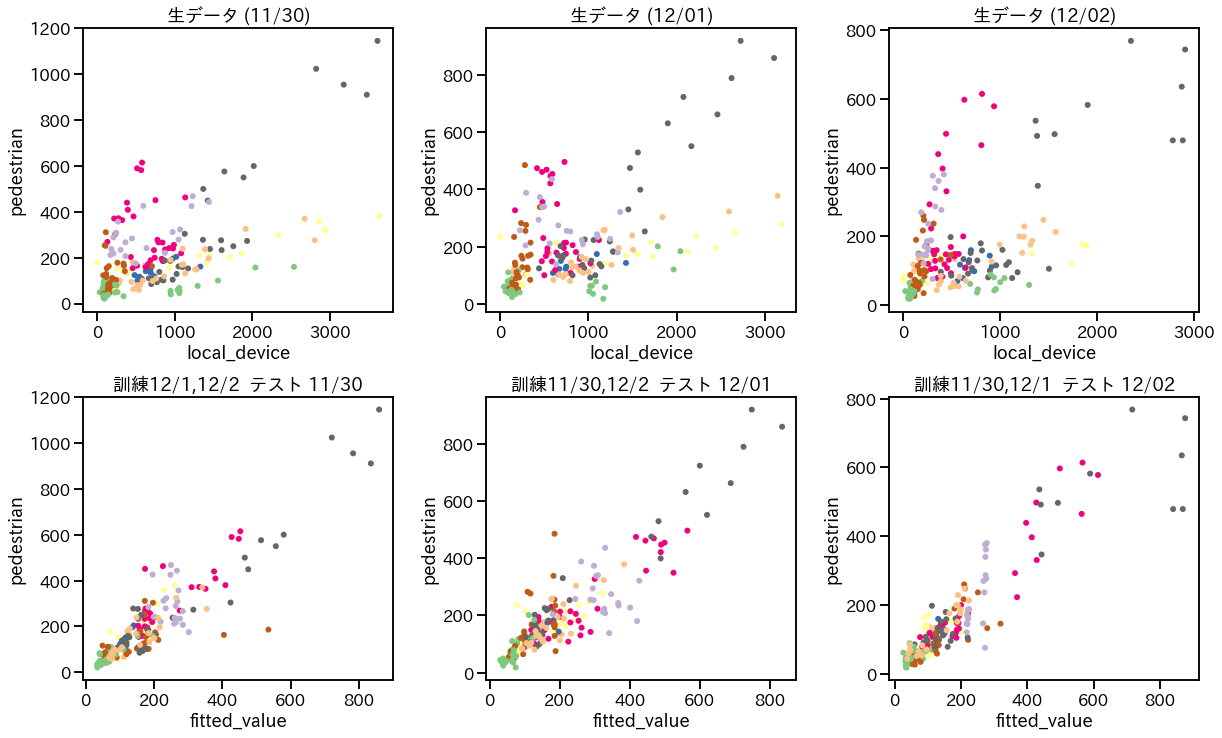

In [88]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

df[0].plot(kind="scatter", ax=axes[0][0], x=explanatory_var, y=response_var, 
            title="生データ (11/30)",
            c="color", colormap='Accent', colorbar=False)
df[0].plot(kind="scatter", ax=axes[1][0], x='fitted_value', y=response_var, 
            title="訓練12/1,12/2  テスト 11/30",
            c="color", colormap='Accent', colorbar=False)
df[1].plot(kind="scatter", ax=axes[0][1], x=explanatory_var, y=response_var, 
            title="生データ (12/01)",
            c="color", colormap='Accent', colorbar=False)
df[1].plot(kind="scatter", ax=axes[1][1], x='fitted_value', y=response_var, 
            title="訓練11/30,12/2  テスト 12/01",
            c="color", colormap='Accent', colorbar=False)
df[2].plot(kind="scatter", ax=axes[0][2], x=explanatory_var, y=response_var, 
            title="生データ (12/02)",
            c="color", colormap='Accent', colorbar=False)
df[2].plot(kind="scatter", ax=axes[1][2], x='fitted_value', y=response_var, 
            title="訓練11/30,12/1  テスト 12/02",
            c="color", colormap='Accent', colorbar=False)